# 1. Importing Data and Packages :

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, accuracy_score, confusion_matrix, roc_curve, auc, 
                             precision_recall_curve,RocCurveDisplay, ConfusionMatrixDisplay,
                             precision_score, recall_score, f1_score, 
                             matthews_corrcoef, roc_auc_score)
import lightgbm as lgb
from gensim.utils import simple_preprocess

## Nos variables :
- **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- **ids**: The id of the tweet ( 2087)
- **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.
- **user**: the user that tweeted (robotickilldozr)
- **text**: the text of the tweet (Lyx is cool)

In [2]:
#importation des données sur google colab

#!curl -L -o sentiment140.zip https://www.kaggle.com/api/v1/datasets/download/kazanova/sentiment140
#!unzip sentiment140.zip -d ./sentiment140_data
#columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
#path = './sentiment140_data/training.1600000.processed.noemoticon.csv'
#df = pd.read_csv(path, sep=',', encoding='latin1', names=columns)

#importation des données sur jupyter

columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
path = 'training.1600000.processed.noemoticon.csv'
df = pd.read_csv(path, sep=',', encoding='latin1', names=columns)

# 2. Data Exploration :

In [3]:
print("Résumé de la DataFrame : \n")
print(df.info())

print("\n Valeur manquante dans la DataFrame : \n")
display(df.isnull().sum())

print("\n Notre DataFrame : \n")
display(df)

Résumé de la DataFrame : 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB
None

 Valeur manquante dans la DataFrame : 



target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64


 Notre DataFrame : 



target         ids                          date      flag  \
0             0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1             0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2             0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3             0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4             0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
1599995       4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996       4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997       4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998       4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999       4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user                                               text  
0        _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1          scotthamilton  is upset that he can't update his Facebook by ...  
2               mattycus  @Kenichan I dived many times for the ball. Man...  
3                ElleCTF    my whole body feels itchy and like its on fire   
4                 Karoli  @nationwideclass no, it's not behaving at all....  
...                  ...                                                ...  
1599995  AmandaMarie1028  Just woke up. Having no school is the best fee...  
1599996      TheWDBoards  TheWDB.com - Very cool to hear old Walt interv...  
1599997           bpbabe  Are you ready for your MoJo Makeover? Ask me f...  
1599998     tinydiamondz  Happy 38th Birthday to my boo of alll time!!! ...  
1599999   RyanTrevMorris  happy #charitytuesday @theNSPCC @SparksCharity...  

[1600000 rows x 6 columns]


 Les valeurs de la variable target : 

[0 4]

 Les valeurs de la variable target modifiées : 

[0 1]

 Nombre de tweets positifs et négatifs : 



0    800000
1    800000
Name: target, dtype: int64


 Visualisation des tweets : 



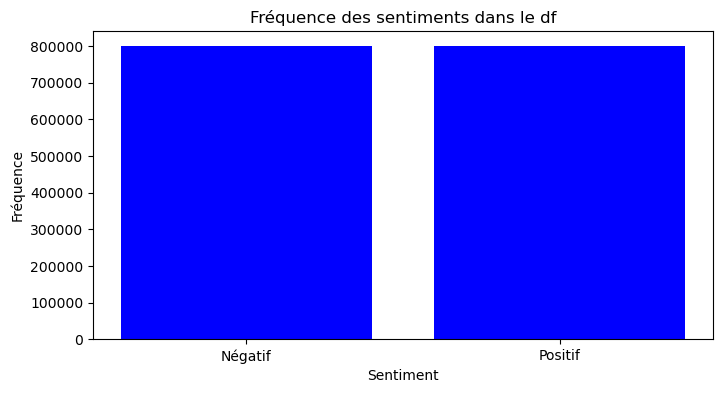

In [4]:
# Vu que on essaye de classifier les tweets en positif ou négatif,
# On va garder que ces 2 variables : target et text
df = df[['target', 'text']]

print("\n Les valeurs de la variable target : \n")
print(df['target'].unique())

# 0 => tweet négatif
# 4 => tweet positif
# 4 => 1
df.loc[df['target']==4, 'target']=1
print("\n Les valeurs de la variable target modifiées : \n")
print(df['target'].unique())

# On va calculer le nombre de tweets positifs et négatifs
target_count = df["target"].value_counts()
print("\n Nombre de tweets positifs et négatifs : \n")
display(target_count)
# Présentation graphique :
print("\n Visualisation des tweets : \n")
plt.figure(figsize=(8,4))
plt.bar(target_count.index, target_count.values, color="blue")
plt.title("Fréquence des sentiments dans le df")
plt.xlabel("Sentiment")
plt.ylabel("Fréquence")
plt.xticks(target_count.index, ["Négatif", "Positif"]) 
plt.show()

In [5]:
# Vu le volume de la DataFrame et par manque de ressources, on va réaliser un échantillonnage
# Cela permettra de travailler efficacement sur le projet.

# Échantillonnage aléatoire de 10 000 tweets positifs et négatifs
positifs_tweets = df[df['target'] == 1].sample(n=10000, random_state=42)
negatifs_tweets = df[df['target'] == 0].sample(n=10000, random_state=42)

# Combiner les deux échantillons dans un DataFrame unique
df_selectionne = pd.concat([positifs_tweets, negatifs_tweets]).reset_index(drop=True)

print("Dataset sélectionné : \n")
display(df_selectionne)

Dataset sélectionné : 



target                                               text
0           1  Is lookin 4ward to a long weekend  really dont...
1           1  #myweakness  Is music and i live to meet the p...
2           1           figured out the Internet on my new iPod 
3           1  @hillsongunited can't wait to worship with you...
4           1  @sillybeggar Congrats James !! I'm sure the bo...
...       ...                                                ...
19995       0  really hates that they are totally messing up ...
19996       0             @BrownSuga3000 THANX FOR TELLING ME!! 
19997       0  really sad that graduation is coming so fast.....
19998       0                              Raining cats n dogs. 
19999       0           Field day.... Gt class...not winning... 

[20000 rows x 2 columns]

# 3. Data Pre-processing :

In [6]:
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

def nettoyage_texte(text):
    if not isinstance(text, str):  # Vérification si le texte est valide
        return ""

    # Supprimer les caractères spéciaux sauf lettres et espaces
    text = re.sub(r"[^\w\s]", "", text)

    # Supprimer les chiffres
    text = re.sub(r"\d+", "", text)  

    # Conversion en minuscule
    text = text.lower()

    # Suppression des URLs, mentions, hashtags et autres artefacts
    text = re.sub(r"http[s]?://\S+", "", text)
    text = re.sub(r"www\.\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#[A-Za-z0-9_]+", "", text)

    # Supprimer les espaces supplémentaires
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenisation
    tokens = word_tokenize(text)

    # Suppression des mots vides (stopwords)
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Relier les tokens nettoyés en une seule chaîne
    texte_nettoye = " ".join(tokens)

    return texte_nettoye

**Différence entre `simple_preprocess` (Gensim) et `nettoyage_texte` 

La fonction **`simple_preprocess`** de Gensim est une préparation basique de texte qui :  
- Convertit en minuscules,  
- Supprime les accents (ex. "é" → "e"),  
- Tokenise le texte en mots de longueur minimale paramétrable.  
Elle est rapide et légère, mais ne gère pas les chiffres, les stopwords, ou les artefacts (URLs, hashtags).  

La fonction **`nettoyage_texte`** est une pipeline complète incluant :  
1. **Nettoyage avancé** : suppression des caractères spéciaux, chiffres, URLs, hashtags, mentions.  
2. **Tokenisation fine** avec `nltk.word_tokenize`.  
3. **Filtrage des stopwords** (mots vides comme "the", "and").  
4. **Normalisation** (minuscules, espaces).  

In [ ]:
# Appliquer le nettoyage : fonction 'nettoyage_texte' qu'on a créé
print(" Dataset séléctionnée nettoyée : \n")
df_selectionne['clean_text']=df_selectionne['text'].apply(nettoyage_texte)

# Appliquer le nettoyage : fonction 'simple_preprocess' de gensim
df_selectionne['clean_text1'] = df_selectionne['text'].apply(lambda x: simple_preprocess(str(x), deacc=True))
display(df_selectionne)

 Dataset séléctionnée nettoyée : 



target                                               text  \
0           1  Is lookin 4ward to a long weekend  really dont...   
1           1  #myweakness  Is music and i live to meet the p...   
2           1           figured out the Internet on my new iPod    
3           1  @hillsongunited can't wait to worship with you...   
4           1  @sillybeggar Congrats James !! I'm sure the bo...   
...       ...                                                ...   
19995       0  really hates that they are totally messing up ...   
19996       0             @BrownSuga3000 THANX FOR TELLING ME!!    
19997       0  really sad that graduation is coming so fast.....   
19998       0                              Raining cats n dogs.    
19999       0           Field day.... Gt class...not winning...    

                                              clean_text  \
0      lookin ward long weekend really dont want go w...   
1                 myweakness music live meet people make   
2                              figured internet new ipod   
3      hillsongunited cant wait worship guys tonight ...   
4      sillybeggar congrats james im sure book going ...   
...                                                  ...   
19995  really hates totally messing new moon favorite...   
19996                            brownsuga thanx telling   
19997  really sad graduation coming fastand im losing...   
19998                                raining cats n dogs   
19999                      field day gt classnot winning   

                                             clean_text1  
0      [is, lookin, ward, to, long, weekend, really, ...  
1      [myweakness, is, music, and, live, to, meet, t...  
2       [figured, out, the, internet, on, my, new, ipod]  
3      [hillsongunited, can, wait, to, worship, with,...  
4      [sillybeggar, congrats, james, sure, the, book...  
...                                                  ...  
19995  [really, hates, that, they, are, totally, mess...  
19996               [brownsuga, thanx, for, telling, me]  
19997  [really, sad, that, graduation, is, coming, so...  
19998                              [raining, cats, dogs]  
19999              [field, day, gt, class, not, winning]  

[20000 rows x 4 columns]

In [8]:
# Cette partie est essentielle pour pouvoir travailler sur clean_text1, 
# afin de ne plus avoir une liste et de pouvoir travailler sur des phrases.
df_selectionne['clean_text11'] = df_selectionne['clean_text1'].apply(lambda x: ' '.join(x))
display(df_selectionne)

target                                               text  \
0           1  Is lookin 4ward to a long weekend  really dont...   
1           1  #myweakness  Is music and i live to meet the p...   
2           1           figured out the Internet on my new iPod    
3           1  @hillsongunited can't wait to worship with you...   
4           1  @sillybeggar Congrats James !! I'm sure the bo...   
...       ...                                                ...   
19995       0  really hates that they are totally messing up ...   
19996       0             @BrownSuga3000 THANX FOR TELLING ME!!    
19997       0  really sad that graduation is coming so fast.....   
19998       0                              Raining cats n dogs.    
19999       0           Field day.... Gt class...not winning...    

                                              clean_text  \
0      lookin ward long weekend really dont want go w...   
1                 myweakness music live meet people make   
2                              figured internet new ipod   
3      hillsongunited cant wait worship guys tonight ...   
4      sillybeggar congrats james im sure book going ...   
...                                                  ...   
19995  really hates totally messing new moon favorite...   
19996                            brownsuga thanx telling   
19997  really sad graduation coming fastand im losing...   
19998                                raining cats n dogs   
19999                      field day gt classnot winning   

                                             clean_text1  \
0      [is, lookin, ward, to, long, weekend, really, ...   
1      [myweakness, is, music, and, live, to, meet, t...   
2       [figured, out, the, internet, on, my, new, ipod]   
3      [hillsongunited, can, wait, to, worship, with,...   
4      [sillybeggar, congrats, james, sure, the, book...   
...                                                  ...   
19995  [really, hates, that, they, are, totally, mess...   
19996               [brownsuga, thanx, for, telling, me]   
19997  [really, sad, that, graduation, is, coming, so...   
19998                              [raining, cats, dogs]   
19999              [field, day, gt, class, not, winning]   

                                            clean_text11  
0      is lookin ward to long weekend really dont wan...  
1      myweakness is music and live to meet the peopl...  
2                figured out the internet on my new ipod  
3      hillsongunited can wait to worship with you gu...  
4      sillybeggar congrats james sure the book is go...  
...                                                  ...  
19995  really hates that they are totally messing up ...  
19996                     brownsuga thanx for telling me  
19997  really sad that graduation is coming so fast a...  
19998                                  raining cats dogs  
19999                     field day gt class not winning  

[20000 rows x 5 columns]

## 3.1. Visualisation avant nettoyage du text : 

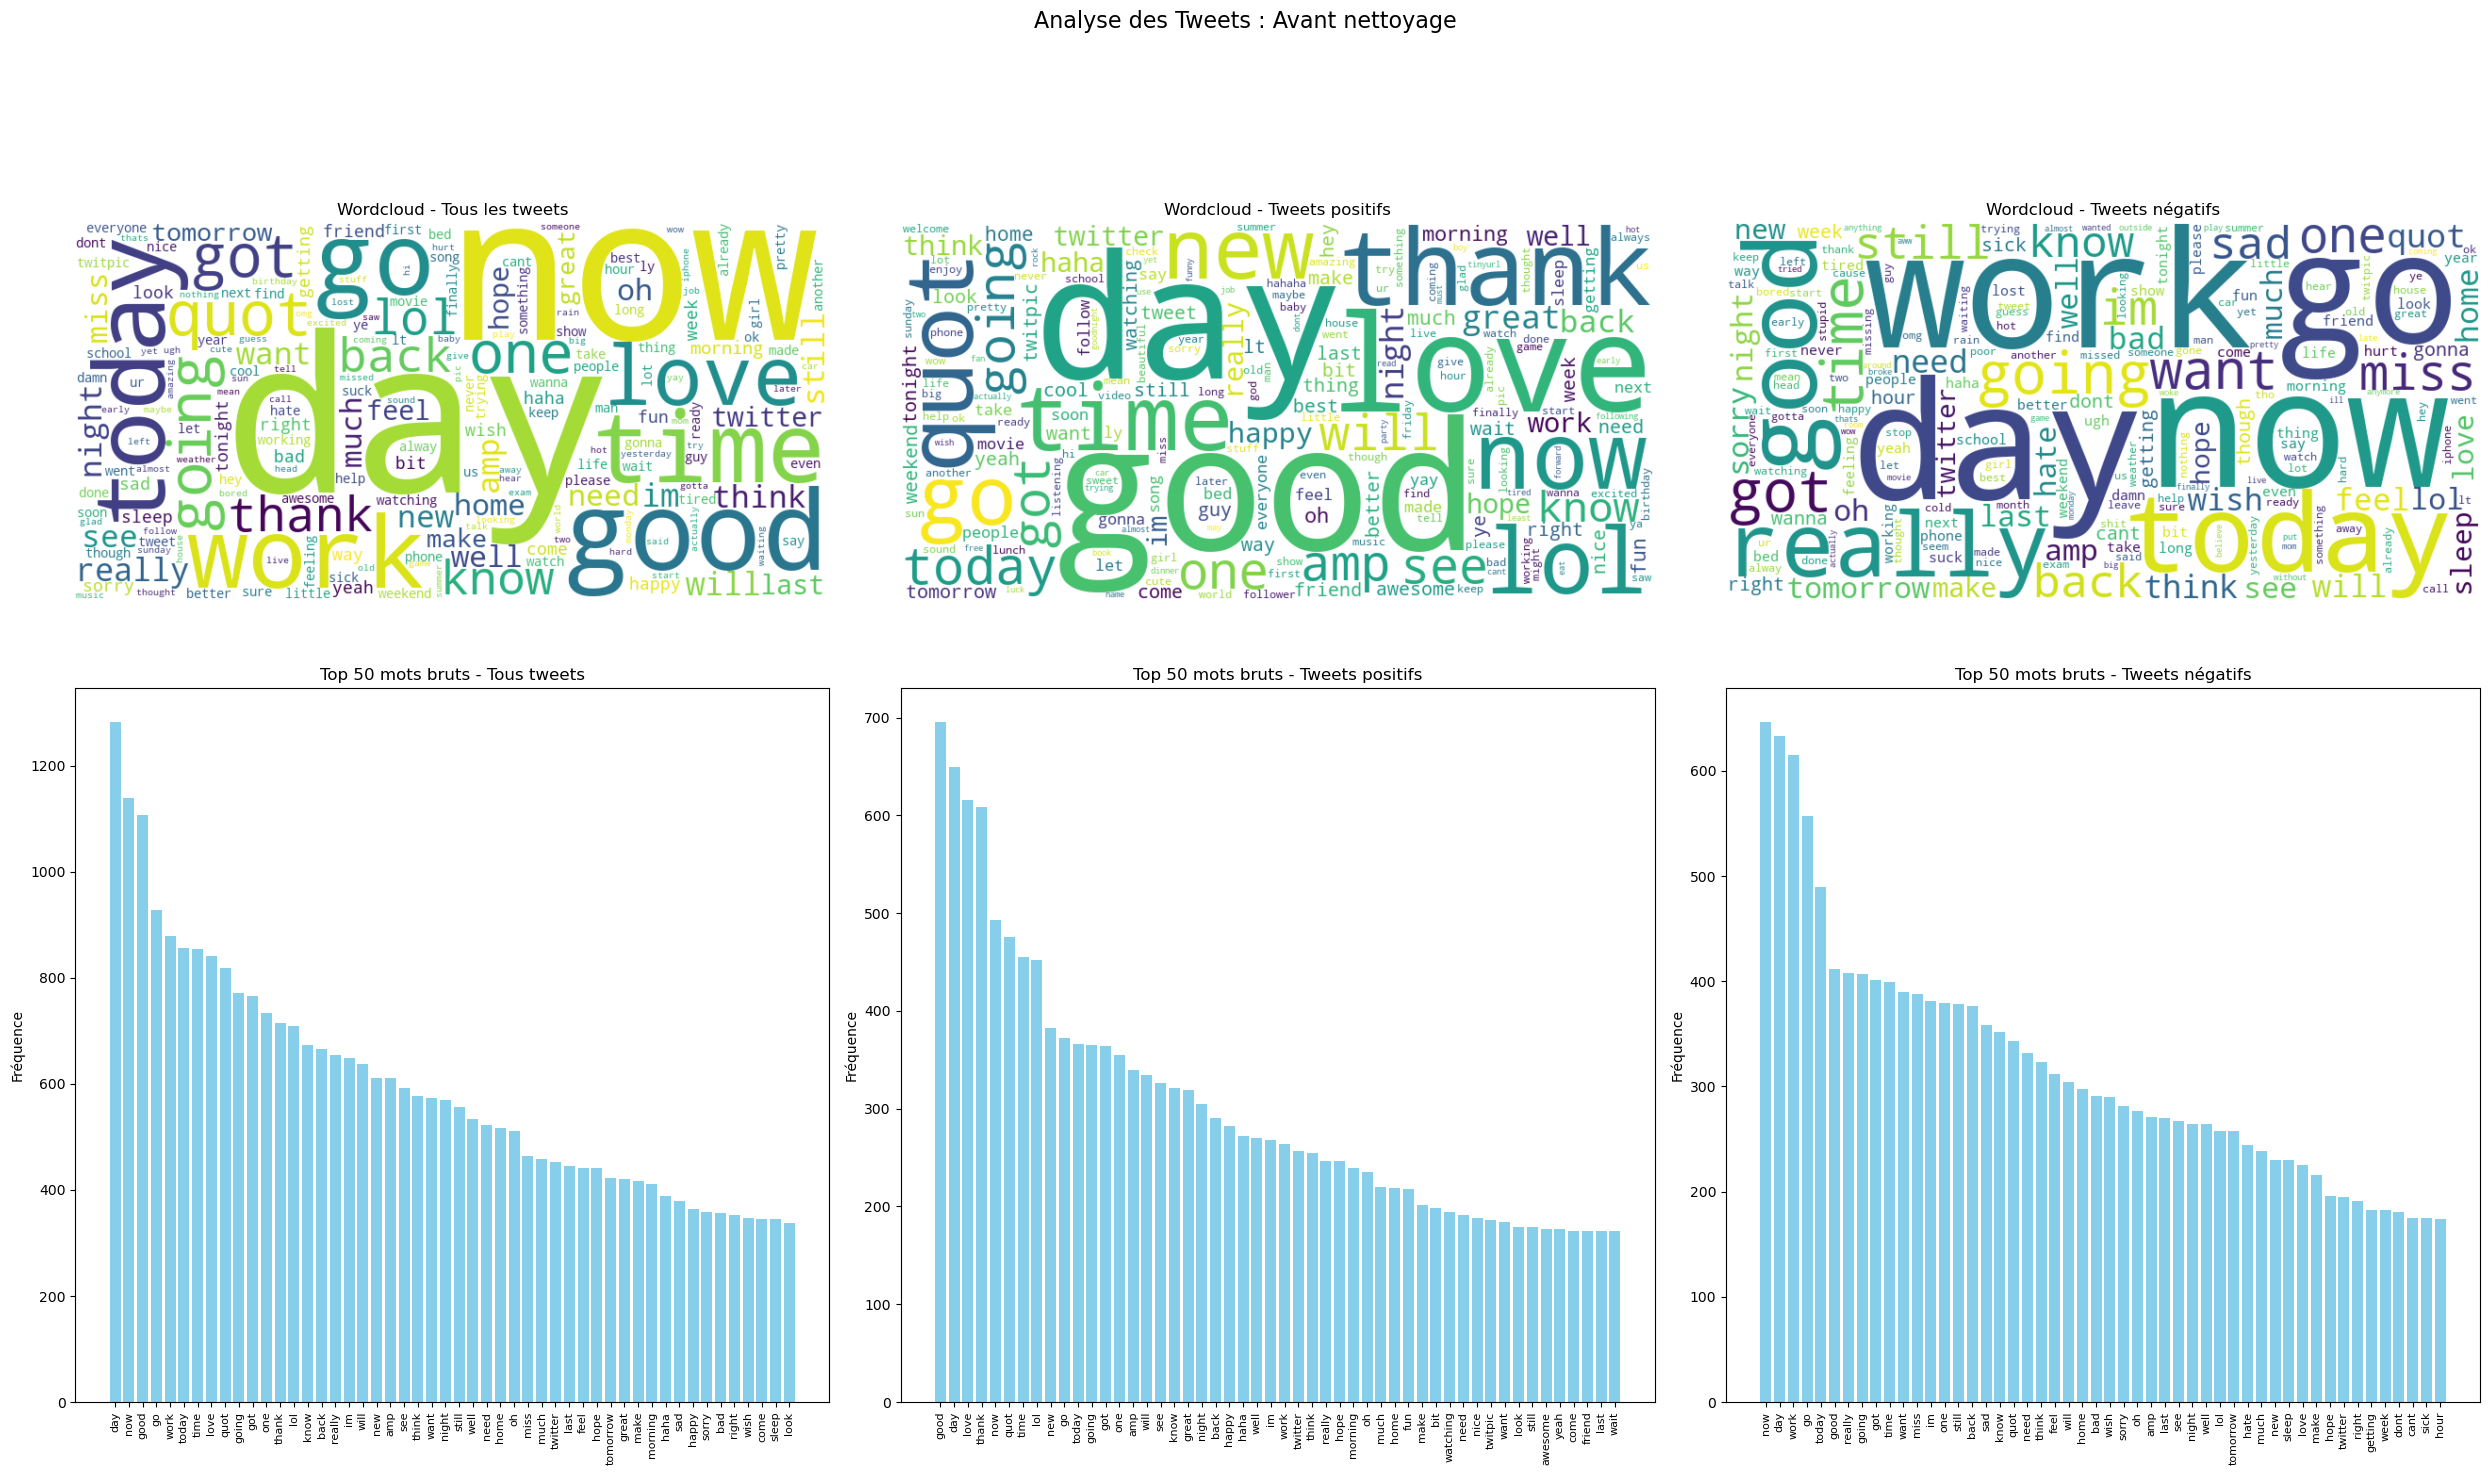

In [ ]:
# Fonction pour concaténer les textes avec des options de filtrage
def concat_text(df, column, target_column="target", target_value=None):
    """Concatène les textes d'une colonne avec option de filtrage sur une colonne cible"""
    if target_value is not None:
        mask = df[target_column] == target_value
        texts = df.loc[mask, column].dropna().str.cat(sep=" ")
    else:
        texts = df[column].dropna().str.cat(sep=" ")
    return texts.lower()  

# Extraction des textes de différentes catégories
all_texts = concat_text(df_selectionne, "text")  
positif_text = concat_text(positifs_tweets, "text")  
negatif_text = concat_text(negatifs_tweets, "text")  

# Configuration des paramètres WordCloud
WC_CONFIG = {
    "width": 800,
    "height": 400,
    "background_color": "white",
    "collocations": False,
    "regexp": r"\w[\w']+"
}

# Fonction pour générer un WordCloud
def generate_wordcloud(text):
    return WordCloud(**WC_CONFIG).generate(text)

# Génération des nuages de mots
all_wordcloud = generate_wordcloud(all_texts)
positif_wordcloud = generate_wordcloud(positif_text)
negatif_wordcloud = generate_wordcloud(negatif_text)

# Fonction pour extraire les mots les plus fréquents
def get_top_words(text, n=50):
    wc = WordCloud(**WC_CONFIG)
    processed_text = wc.process_text(text)
    sorted_words = sorted(processed_text.items(), key=lambda x: (-x[1], x[0]))[:n]
    return zip(*sorted_words) if sorted_words else ([], [])

# Extraction des top mots
all_words, all_counts = get_top_words(all_texts)
positif_words, positif_counts = get_top_words(positif_text)
negatif_words, negatif_counts = get_top_words(negatif_text)


# Configuration des graphiques
fig, axes = plt.subplots(2, 3, figsize=(25, 15))

# 1. WordCloud - Tous les tweets
axes[0, 0].imshow(all_wordcloud, interpolation="bilinear")
axes[0, 0].set_title("Wordcloud - Tous les tweets", fontsize=12)
axes[0, 0].axis("off")

# 2. Top 50 mots bruts - Tous les tweets
if len(all_words) > 0:
    bars = axes[1, 0].bar(all_words, all_counts, color='skyblue')
    axes[1, 0].set_title("Top 50 mots bruts - Tous tweets", fontsize=12)
    axes[1, 0].tick_params(axis='x', rotation=90, labelsize=8)
    axes[1, 0].set_ylabel("Fréquence")  # Ajout du label Y

# 3. WordCloud - Tweets positifs
axes[0, 1].imshow(positif_wordcloud, interpolation="bilinear")
axes[0, 1].set_title("Wordcloud - Tweets positifs", fontsize=12)
axes[0, 1].axis("off")

# 4. Top 50 mots bruts - Tweets positifs
if len(positif_words) > 0:
    bars = axes[1, 1].bar(positif_words, positif_counts, color='skyblue')
    axes[1, 1].set_title("Top 50 mots bruts - Tweets positifs", fontsize=12)
    axes[1, 1].tick_params(axis='x', rotation=90, labelsize=8)
    axes[1, 1].set_ylabel("Fréquence")  # Ajout du label Y

# 5. WordCloud - Tweets négatifs
axes[0, 2].imshow(negatif_wordcloud, interpolation="bilinear")
axes[0, 2].set_title("Wordcloud - Tweets négatifs", fontsize=12)
axes[0, 2].axis("off")

# 6. Top 50 mots bruts - Tweets négatifs
if len(negatif_words) > 0:
    bars = axes[1, 2].bar(negatif_words, negatif_counts, color='skyblue')
    axes[1, 2].set_title("Top 50 mots bruts - Tweets négatifs", fontsize=12)
    axes[1, 2].tick_params(axis='x', rotation=90, labelsize=8)
    axes[1, 2].set_ylabel("Fréquence")  # Ajout du label Y

# Ajustements finaux
plt.tight_layout()
plt.suptitle("Analyse des Tweets : Avant nettoyage", fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

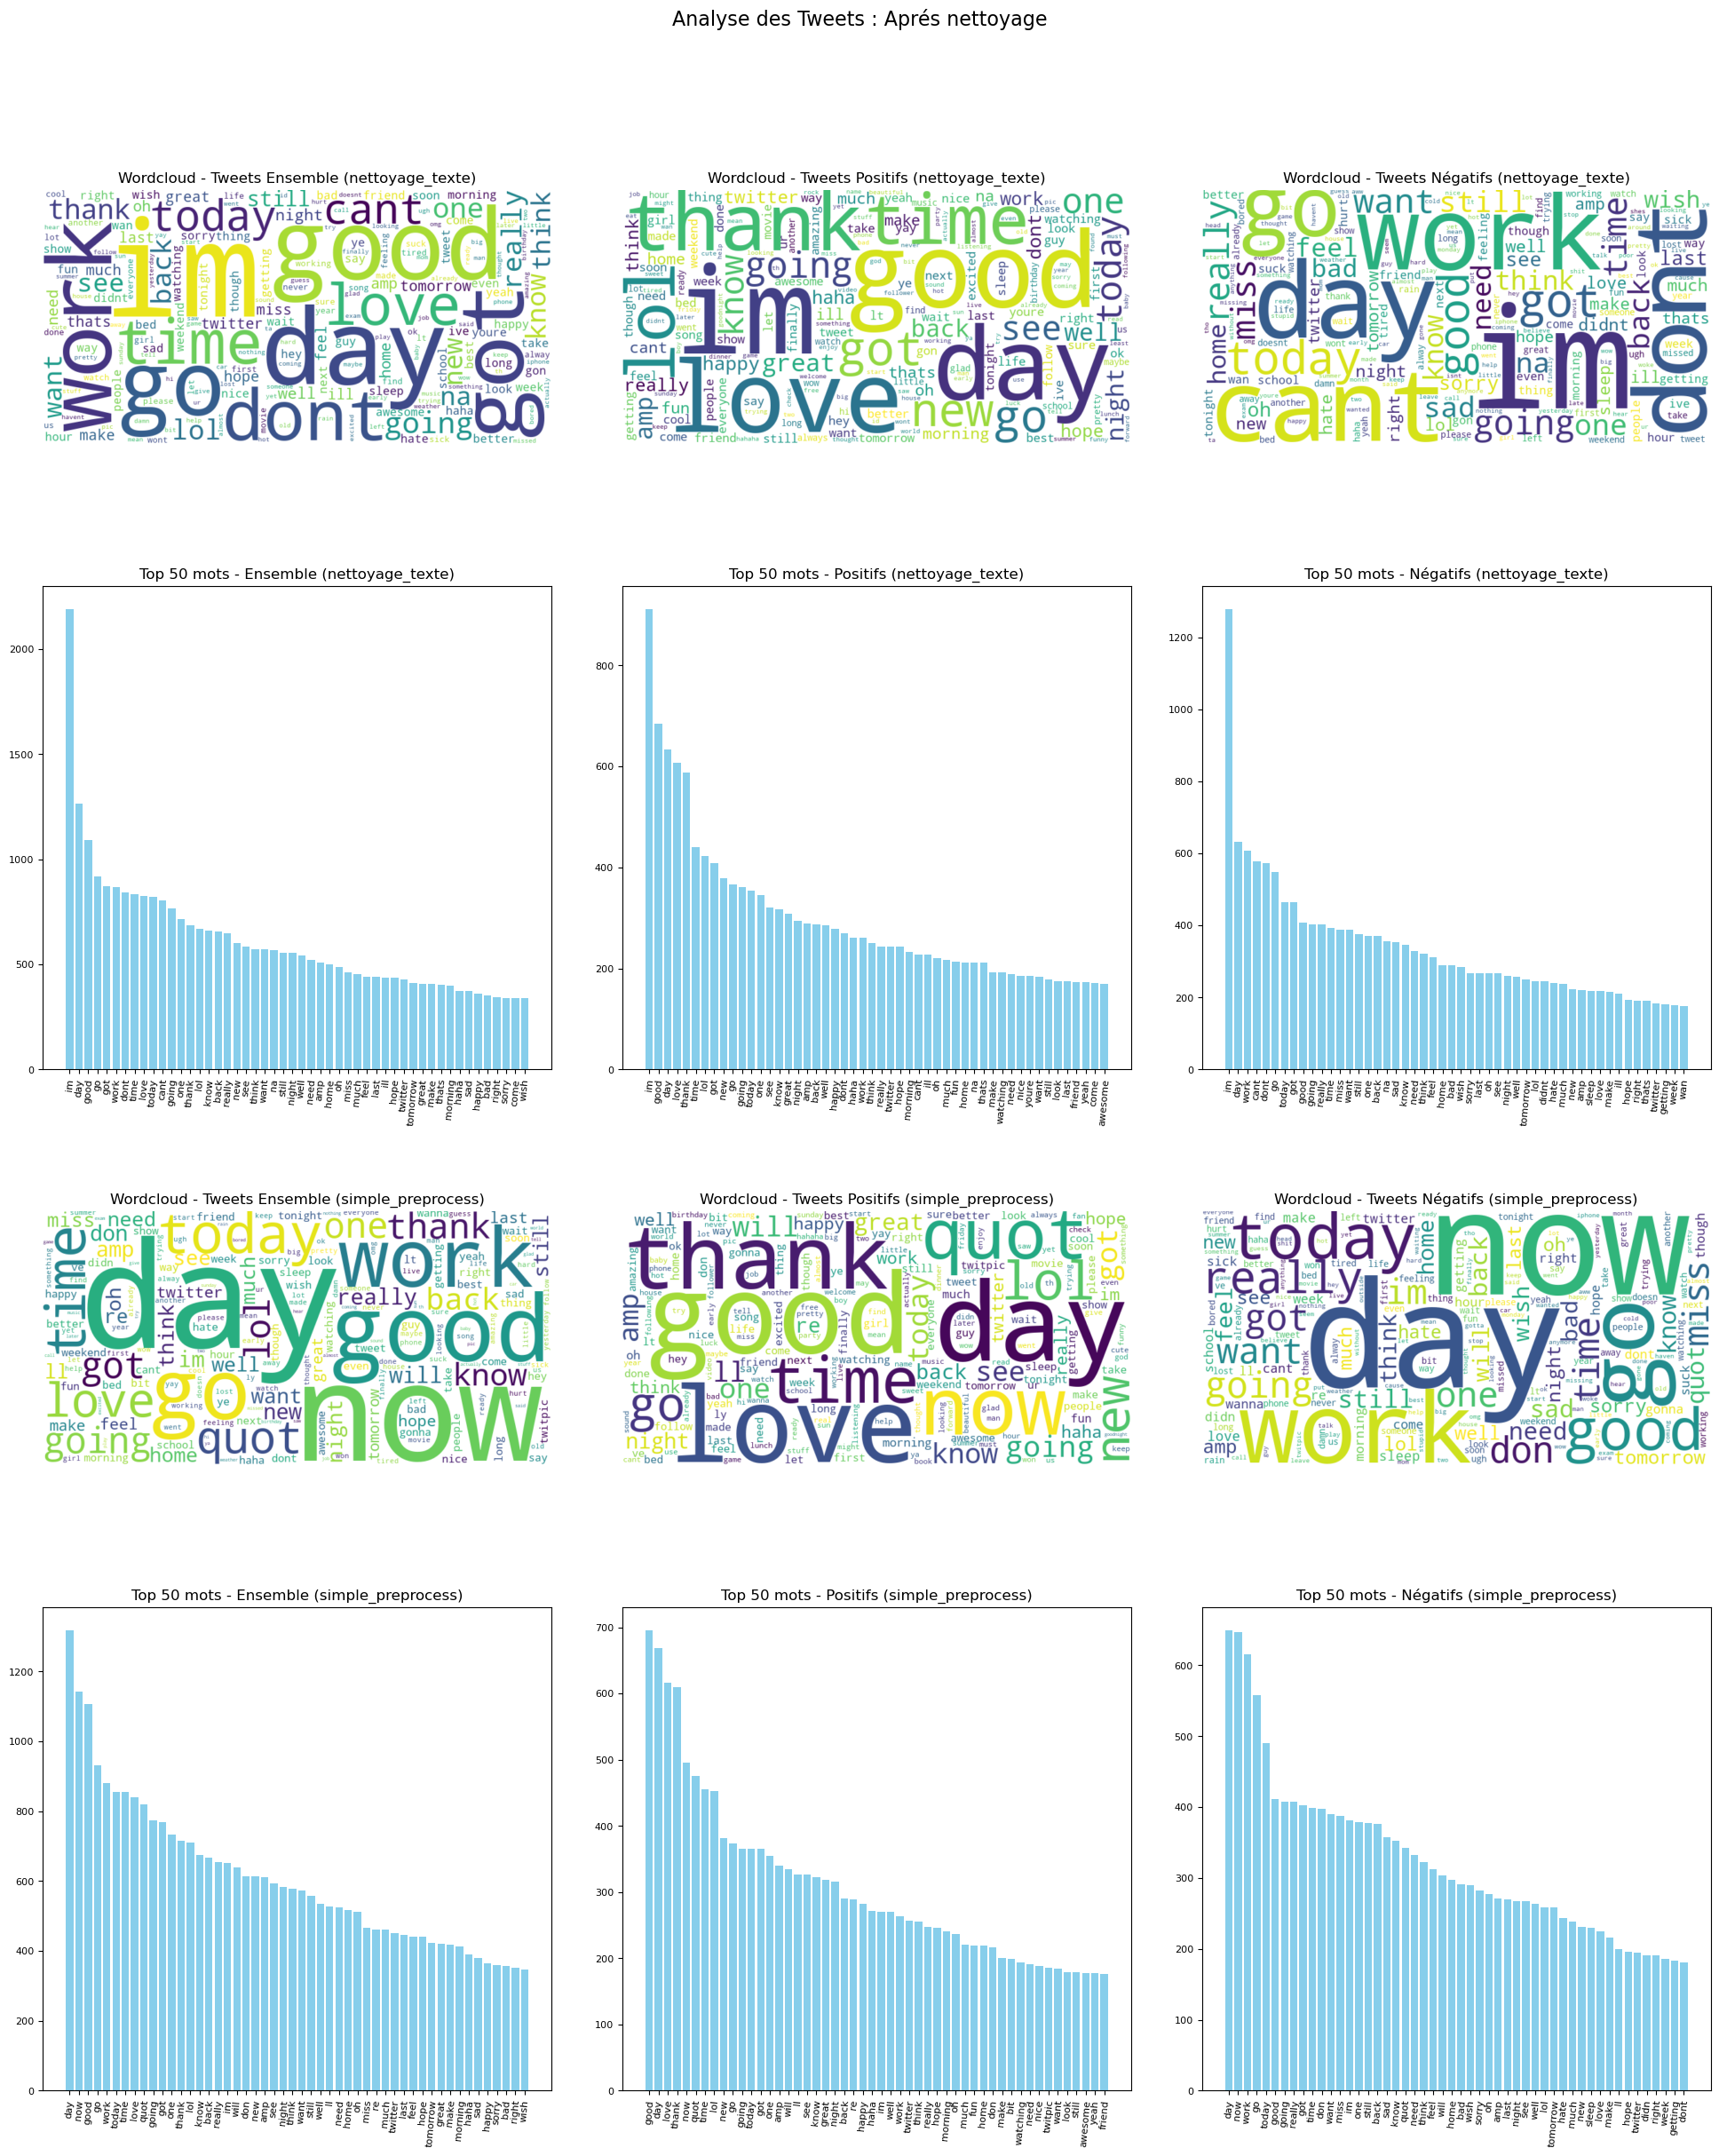

In [15]:
# Fonction de concaténation améliorée
def concat_text(df, column, target=None):
    # Filtrage et concaténation
    if target is not None:
        texts = df.loc[df["target"] == target, column].dropna().str.cat(sep=" ")
    else:
        texts = df[column].dropna().str.cat(sep=" ")
    
    # Normalisation supplémentaire (minuscules)
    return texts.lower()

# Extraction des textes
all_texts = concat_text(df_selectionne, "clean_text")
positif_texts = concat_text(df_selectionne, "clean_text", 1)
negatif_texts = concat_text(df_selectionne, "clean_text", 0)
all_texts1 = concat_text(df_selectionne, "clean_text11")
positif_texts1 = concat_text(df_selectionne, "clean_text11", 1)
negatif_texts1 = concat_text(df_selectionne, "clean_text11", 0)

# Configuration commune pour les WordClouds
WC_CONFIG = {
    "width": 800,
    "height": 400,
    "background_color": "white",
    "collocations": False,  
    "regexp": r"\w[\w']+"  
}

# Génération des WordClouds
def generate_wordcloud(text):
    return WordCloud(**WC_CONFIG).generate(text)

all_wordcloud = generate_wordcloud(all_texts)
positif_wordcloud = generate_wordcloud(positif_texts)
negatif_wordcloud = generate_wordcloud(negatif_texts)
all_wordcloud1 = generate_wordcloud(all_texts1)
positif_wordcloud1 = generate_wordcloud(positif_texts1)
negatif_wordcloud1 = generate_wordcloud(negatif_texts1)

# Nouvelle fonction d'extraction des mots avec le même traitement que WordCloud
def get_top_words(text, n=50):
    wc = WordCloud(**WC_CONFIG)
    processed_text = wc.process_text(text)  # Même traitement que pour les WordClouds
    sorted_words = sorted(processed_text.items(), key=lambda x: (-x[1], x[0]))[:n]
    return zip(*sorted_words) if sorted_words else ([], [])

# Extraction des données pour les graphiques à barres
all_words, all_counts = get_top_words(all_texts)
positif_words, positif_counts = get_top_words(positif_texts)
negatif_words, negatif_counts = get_top_words(negatif_texts)
all_words1, all_counts1 = get_top_words(all_texts1)
positif_words1, positif_counts1 = get_top_words(positif_texts1)
negatif_words1, negatif_counts1 = get_top_words(negatif_texts1)

# Création de la figure
fig, axes = plt.subplots(4, 3, figsize=(20, 25))

# Ligne 1: Wordclouds texte_nettoyage
for ax, wc, title in zip(axes[0], [all_wordcloud, positif_wordcloud, negatif_wordcloud], 
                        ["Ensemble", "Positifs", "Négatifs"]):
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Wordcloud - Tweets {title} (nettoyage_texte)", fontsize=12)
    ax.axis("off")

# Ligne 2: Top mots texte_nettoyage
for ax, words, counts, title in zip(axes[1], 
                                   [all_words, positif_words, negatif_words],
                                   [all_counts, positif_counts, negatif_counts],
                                   ["Ensemble", "Positifs", "Négatifs"]):
    ax.bar(words, counts, color="skyblue")
    ax.set_title(f"Top 50 mots - {title} (nettoyage_texte)", fontsize=12)
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=85, fontsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Ligne 3: Wordclouds simple_preprocess
for ax, wc, title in zip(axes[2], [all_wordcloud1, positif_wordcloud1, negatif_wordcloud1], 
                        ["Ensemble", "Positifs", "Négatifs"]):
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Wordcloud - Tweets {title} (simple_preprocess)", fontsize=12)
    ax.axis("off")

# Ligne 4: Top mots simple_preprocess
for ax, words, counts, title in zip(axes[3], 
                                   [all_words1, positif_words1, negatif_words1],
                                   [all_counts1, positif_counts1, negatif_counts1],
                                   ["Ensemble", "Positifs", "Négatifs"]):
    ax.bar(words, counts, color="skyblue")
    ax.set_title(f"Top 50 mots - {title} (simple_preprocess)", fontsize=12)
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=85, fontsize=8)
    ax.tick_params(axis='y', labelsize=8)

# Ajustements finaux
plt.tight_layout(pad=3.0)
plt.subplots_adjust(top=0.95)
plt.suptitle("Analyse des Tweets : Aprés nettoyage", fontsize=16)
plt.show()

# 4. Convert text to numbers : TF - IDF

In [16]:
# Matrice TF - IDF : Pour les données néttoyées avec 'simple_preprocess'

tfidf_vectorizer = TfidfVectorizer()
# Transformation des textes en vecteurs TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(df_selectionne['clean_text11'])
# Afficher la matrice TF-IDF
print(X_tfidf.shape) 

(20000, 29371)


In [17]:
# # Matrice TF - IDF : Pour les données néttoyées avec 'nettoyage_texte'

vectorizer = TfidfVectorizer()
features = vectorizer.fit_transform(df_selectionne['clean_text'])
features = features.toarray()
print(features.shape)

(20000, 32343)


# 5. Training and test Datasets :

In [ ]:
# Training et test datasets 1 : fonction utilisée 'nettoyage_texte'

X_train, X_test, y_train, y_test = train_test_split(features, df_selectionne['target'],
                                                    test_size=0.2, random_state=42, stratify=df_selectionne['target'])
print("Taille de la training dataset : ", X_train.shape, y_train.shape)
print("\nTaille de la test dataset : ", X_test.shape, y_test.shape)

Taille de la training dataset :  (16000, 32343) (16000,)

Taille de la test dataset :  (4000, 32343) (4000,)


In [ ]:
# Training et test datasets 2 : fonction utilisée 'simple_preprocess'

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_tfidf, df_selectionne['target'],
                                                    test_size=0.2, random_state=42, stratify=df_selectionne['target'])
print("Taille de la training dataset : ", X_train1.shape, y_train1.shape)
print("\nTaille de la test dataset : ", X_test1.shape, y_test1.shape)

Taille de la training dataset :  (16000, 29371) (16000,)

Taille de la test dataset :  (4000, 29371) (4000,)


# I. Models :

## Modèle 01 : LogisticRegression : 
### Définition : 
 La régression logistique est un algorithme d'apprentissage supervisé utilisé principalement pour des tâches de classification binaire. Elle estime la probabilité qu'une observation appartienne à une classe donnée en utilisant la fonction sigmoïde pour transformer une combinaison linéaire des caractéristiques en une probabilité entre 0 et 1. 
### Fonctionnement : 
### 1. Formule mathématique : 
où : 
![Texte alternatif](https://th.bing.com/th/id/R.62bb62eb775c493d0dfebc5179a1a388?rik=K2DXxTcZK2qM2A&riu=http%3a%2f%2ffaculty.cas.usf.edu%2fmbrannick%2fregression%2fgifs%2flo4.gif&ehk=QYTqg8E6Pz4u6rOwyRV%2fOLkT%2fIddTdnOp3x7TuaoQ%2fo%3d&risl=&pid=ImgRaw&r=0)

- 𝑋 : représente les variables d'entrée (features),
- h et a : sont les coefficients appris par le modèle,
- 𝑒 : est la base du logarithme naturel.
### 2. Entraînement du modèle :
- Le modèle ajuste les coefficients h et a en minimisant la fonction de perte log-likelihood via l'optimisation (comme la descente de gradient).
- L'hyperparamètre max_iter=1000 spécifie le nombre maximum d'itérations pour la convergence.
- random_state=42 assure la reproductibilité des résultats.
### 3. Prédiction : 
- Une fois entraîné, le modèle applique la fonction sigmoïde pour générer une probabilité pour chaque échantillon.
- Par défaut, si cette probabilité est ≥ 0.5, l'observation est classée dans la classe positive (1), sinon dans la classe négative (0).

In [ ]:
# Modèle 01 : LogisticRegression
# Pour le Training Datasets 1
model1 = LogisticRegression(max_iter=1000, random_state=42)
model1.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [21]:
# Pour le Training Datasets 2
model11 = LogisticRegression(max_iter=1000, random_state=42)
model11.fit(X_train1, y_train1)

LogisticRegression(max_iter=1000, random_state=42)

In [22]:
# Prédictions
y_pred1 = model1.predict(X_test) # test datasets 1
y_pred11 = model11.predict(X_test1) # test datasets 2

In [23]:
# Evaluation
print("Rapport modèle 01 : LogisticRegression : \n", classification_report(y_test, y_pred1))
print("Rapport modèle 01 : LogisticRegression - 1 : \n", classification_report(y_test1, y_pred11))

Rapport modèle 01 : LogisticRegression : 
               precision    recall  f1-score   support

           0       0.76      0.71      0.73      2000
           1       0.73      0.77      0.75      2000

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000

Rapport modèle 01 : LogisticRegression - 1 : 
               precision    recall  f1-score   support

           0       0.77      0.75      0.76      2000
           1       0.76      0.78      0.77      2000

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



## Modèle 02 : RandomForestClassifier : 
### Définition :
 Le Random Forest est un algorithme d'apprentissage supervisé basé sur un ensemble d'arbres de décision. Il est utilisé pour des tâches de classification et de régression. L'idée principale est de construire plusieurs arbres de décision indépendamment et de combiner leurs prédictions pour améliorer la robustesse et la précision du modèle.
### Fonctionnement : 
### 1. Construction de plusieurs arbres de décision :
- L'algorithme génère n_estimators arbres de décision.
- Chaque arbre est entraîné sur un échantillon aléatoire des données (bootstrap sampling).
- À chaque nœud, un sous-ensemble aléatoire des variables est sélectionné pour réduire la corrélation entre les arbres.
### 2. Prédiction :
- Pour la classification, chaque arbre prédit une classe.
- La classe finale est déterminée par vote majoritaire parmi tous les arbres.
- Cela réduit le surapprentissage comparé à un arbre de décision unique.
### 3. Paramètres utilisés :
- n_estimators=10 : Nombre d'arbres dans la forêt (plus il y en a, plus la prédiction est stable).
- random_state=42 : Fixe la graine aléatoire pour assurer la reproductibilité.

In [24]:
# Modèle 02 : RandomForestClassifier
# Pour le Training Datasets 1
model2 = RandomForestClassifier(n_estimators=10, random_state=42)
model2.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=42)

In [25]:
# Pour le Training Datasets 2
model22 = RandomForestClassifier(n_estimators=10, random_state=42)
model22.fit(X_train1, y_train1)

RandomForestClassifier(n_estimators=10, random_state=42)

In [26]:
# Prédictions
y_pred2 = model2.predict(X_test) # test Datasets 1
y_pred22 = model22.predict(X_test1) # test Datasets 2

In [27]:
# Evaluation
print("\n Rapport modèle 02 : RandomForestClassifier : \n", classification_report(y_test, y_pred2))
print("\n Rapport modèle 02 : RandomForestClassifier - 1 : \n", classification_report(y_test1, y_pred22))


 Rapport modèle 02 : RandomForestClassifier : 
               precision    recall  f1-score   support

           0       0.68      0.75      0.71      2000
           1       0.72      0.65      0.68      2000

    accuracy                           0.70      4000
   macro avg       0.70      0.70      0.70      4000
weighted avg       0.70      0.70      0.70      4000


 Rapport modèle 02 : RandomForestClassifier - 1 : 
               precision    recall  f1-score   support

           0       0.69      0.77      0.73      2000
           1       0.74      0.66      0.70      2000

    accuracy                           0.71      4000
   macro avg       0.72      0.71      0.71      4000
weighted avg       0.72      0.71      0.71      4000



## Modèle 03 : SGDClassifier : 
### Définition : 
 Le SGDClassifier (Stochastic Gradient Descent Classifier) est un modèle linéaire de classification qui utilise la descente de gradient stochastique pour optimiser les paramètres du modèle. Il est particulièrement adapté aux grands jeux de données, car il met à jour les poids itérativement en considérant un échantillon unique à chaque itération, au lieu d'utiliser l'ensemble des données comme dans les méthodes classiques.
### Fonctionnement :
### 1. Optimisation avec la descente de gradient stochastique :

- Contrairement aux algorithmes qui utilisent toute la base d’apprentissage pour ajuster les paramètres, SGD met à jour les poids après chaque observation, ce qui le rend efficace sur de grands volumes de données.
- L’apprentissage se fait en minimisant une fonction de perte définie par l'utilisateur.
### 2. Paramètres utilisés :
- loss="log_loss" : Utilise la régression logistique comme fonction de perte, ce qui permet d’obtenir un modèle similaire à la régression logistique mais avec un apprentissage plus rapide grâce à SGD.
- penalty="l2" : Applique une régularisation L2 (Ridge) pour éviter le surapprentissage.
- max_iter=1000 : Définit le nombre maximal d'itérations pour la convergence.
- random_state=42 : Assure la reproductibilité des résultats.
### 3. Prédiction :
- Après entraînement, le modèle prédit la classe d’un échantillon en calculant une combinaison linéaire des caractéristiques suivie d'une transformation sigmoïde pour obtenir une probabilité.
- Une classe est attribuée en fonction d’un seuil (par défaut 0.5).

In [ ]:
# Modèle 03 : SGDClassifier 
# Pour le Training Datasets 1
model3 = SGDClassifier(loss="log_loss", penalty="l2", max_iter=1000, random_state=42)
model3.fit(X_train, y_train)

SGDClassifier(loss='log_loss', random_state=42)

In [29]:
# Pour le Training Datasets 2
model33 = SGDClassifier(loss="log_loss", penalty="l2", max_iter=1000, random_state=42)
model33.fit(X_train1, y_train1)

SGDClassifier(loss='log_loss', random_state=42)

In [30]:
# Prédictions
y_pred3 = model3.predict(X_test) # test Datasets 1
y_pred33=model33.predict(X_test1) # test Datasets 2

In [31]:
# Evaluation
print("\n Rapport modèle 03 : SGDClassifier : \n", classification_report(y_test, y_pred3))
print("\n Rapport modèle 03 : SGDClassifier - 1 : \n", classification_report(y_test1, y_pred33))


 Rapport modèle 03 : SGDClassifier : 
               precision    recall  f1-score   support

           0       0.79      0.65      0.71      2000
           1       0.70      0.83      0.76      2000

    accuracy                           0.74      4000
   macro avg       0.75      0.74      0.74      4000
weighted avg       0.75      0.74      0.74      4000


 Rapport modèle 03 : SGDClassifier - 1 : 
               precision    recall  f1-score   support

           0       0.77      0.74      0.75      2000
           1       0.75      0.78      0.77      2000

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



## Modèle 04 : LGBMClassifier : 
### Définition :
 Le LGBMClassifier (LightGBM Classifier) est un algorithme d’apprentissage supervisé basé sur les arbres de décision en boosting. Il est optimisé pour être rapide et efficace, tout en consommant moins de mémoire que d’autres modèles comme XGBoost. LightGBM est particulièrement performant sur de grands ensembles de données et lorsqu’il y a beaucoup de variables.
### Fonctionnement : 
### 1. Boosting par gradient :
- LightGBM utilise le Gradient Boosting pour construire un ensemble d’arbres de décision successifs.
- Chaque arbre tente de corriger les erreurs commises par les arbres précédents.
- Contrairement aux algorithmes classiques qui divisent les données niveau par niveau (approche horizontale), LightGBM utilise une approche verticale (leaf-wise), ce qui accélère l’apprentissage.
### 2. Paramètres utilisés :
- n_estimators=100 : Nombre d’arbres de décision dans l’ensemble (plus il y en a, plus la précision est élevée, mais au risque de surapprentissage).
- num_leaves=31 : Nombre maximal de feuilles par arbre (plus il y en a, plus l'arbre peut capturer de complexité).
- random_state=42 : Fixe la graine aléatoire pour assurer la reproductibilité.
### 3. Prédiction :
- Une fois entraîné, le modèle agrège les prédictions des différents arbres et génère une probabilité pour chaque classe.
- La classe avec la probabilité la plus élevée est choisie comme sortie.

In [32]:
# Modèle 04 : LGBMClassifier
# Pour le Training Datasets 1
model4 = lgb.LGBMClassifier(n_estimators=100, num_leaves=31, random_state=42)
model4.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 8000, number of negative: 8000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 24331
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 841
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(random_state=42)

In [33]:
# Pour le Training Datasets 2
model44 = lgb.LGBMClassifier(n_estimators=100, num_leaves=31, random_state=42)
model44.fit(X_train1, y_train1)

[LightGBM] [Info] Number of positive: 8000, number of negative: 8000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39329
[LightGBM] [Info] Number of data points in the train set: 16000, number of used features: 981
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


LGBMClassifier(random_state=42)

In [34]:
# Prédictions
y_pred4 = model4.predict(X_test) # test Datasets 1
y_pred44 = model44.predict(X_test1) # test Datasets 2

In [35]:
# Evaluation
print("\n Rapport modèle 04 : LGBMClassifier : \n", classification_report(y_test, y_pred4))
print("\n Rapport modèle 04 : LGBMClassifier - 1 : \n", classification_report(y_test1, y_pred44))


 Rapport modèle 04 : LGBMClassifier : 
               precision    recall  f1-score   support

           0       0.76      0.63      0.69      2000
           1       0.69      0.80      0.74      2000

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.71      4000
weighted avg       0.72      0.72      0.71      4000


 Rapport modèle 04 : LGBMClassifier - 1 : 
               precision    recall  f1-score   support

           0       0.77      0.70      0.73      2000
           1       0.73      0.78      0.75      2000

    accuracy                           0.74      4000
   macro avg       0.75      0.74      0.74      4000
weighted avg       0.75      0.74      0.74      4000



## Modèle 05 : RidgeClassifier : 
### Définition :
 Le RidgeClassifier est un modèle de classification linéaire basé sur la régression Ridge (L2). Il est similaire à la régression logistique, mais au lieu d'utiliser une fonction de coût basée sur l'entropie croisée, il minimise l'erreur quadratique avec une pénalisation L2. Ce modèle est particulièrement utile lorsque les variables sont corrélées et que l'on souhaite éviter le surapprentissage.
### Fonctionnement :
### 1. Régression linéaire pour la classification :
- Le modèle apprend une combinaison linéaire des caractéristiques pour prédire la classe d’un échantillon.
- Il applique une pénalisation L2 sur les coefficients pour éviter les valeurs extrêmes et améliorer la généralisation.
- Contrairement à la régression logistique qui utilise une fonction sigmoïde pour calculer une probabilité, RidgeClassifier attribue directement une classe en fonction du signe de la sortie du modèle.
### 2. Paramètres utilisés :
- alpha=1.0 : Contrôle l’intensité de la régularisation L2 (plus alpha est élevé, plus la régularisation est forte).
- random_state=42 : Fixe la graine aléatoire pour assurer la reproductibilité des résultats.
### 3. Prédiction :
- Le modèle prédit la classe en calculant une combinaison linéaire des variables d’entrée, suivie d’une affectation basée sur le signe du résultat.
- Si le score est positif, une classe est attribuée, sinon une autre.

In [36]:
# Modèle 05 : RidgeClassifier
# Pour le Training Datasets 1
model5 = RidgeClassifier(alpha=1.0, random_state=42)
model5.fit(X_train, y_train)

RidgeClassifier(random_state=42)

In [37]:
# Pour le Training Datasets 1
model55 = RidgeClassifier(alpha=1.0, random_state=42)
model55.fit(X_train1, y_train1)

RidgeClassifier(random_state=42)

In [38]:
# Prédictions
y_pred5 = model5.predict(X_test) # test Datasets 1
y_pred55 = model55.predict(X_test1) # test Datasets 1

In [39]:
# Evaluation
print("\n Rapport modèle 05 : RidgeClassifier : \n", classification_report(y_test, y_pred5))
print("\n Rapport modèle 05 : RidgeClassifier - 1 : \n", classification_report(y_test1, y_pred55))


 Rapport modèle 05 : RidgeClassifier : 
               precision    recall  f1-score   support

           0       0.74      0.71      0.73      2000
           1       0.72      0.75      0.74      2000

    accuracy                           0.73      4000
   macro avg       0.73      0.73      0.73      4000
weighted avg       0.73      0.73      0.73      4000


 Rapport modèle 05 : RidgeClassifier - 1 : 
               precision    recall  f1-score   support

           0       0.76      0.74      0.75      2000
           1       0.75      0.77      0.76      2000

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.75      0.75      0.75      4000



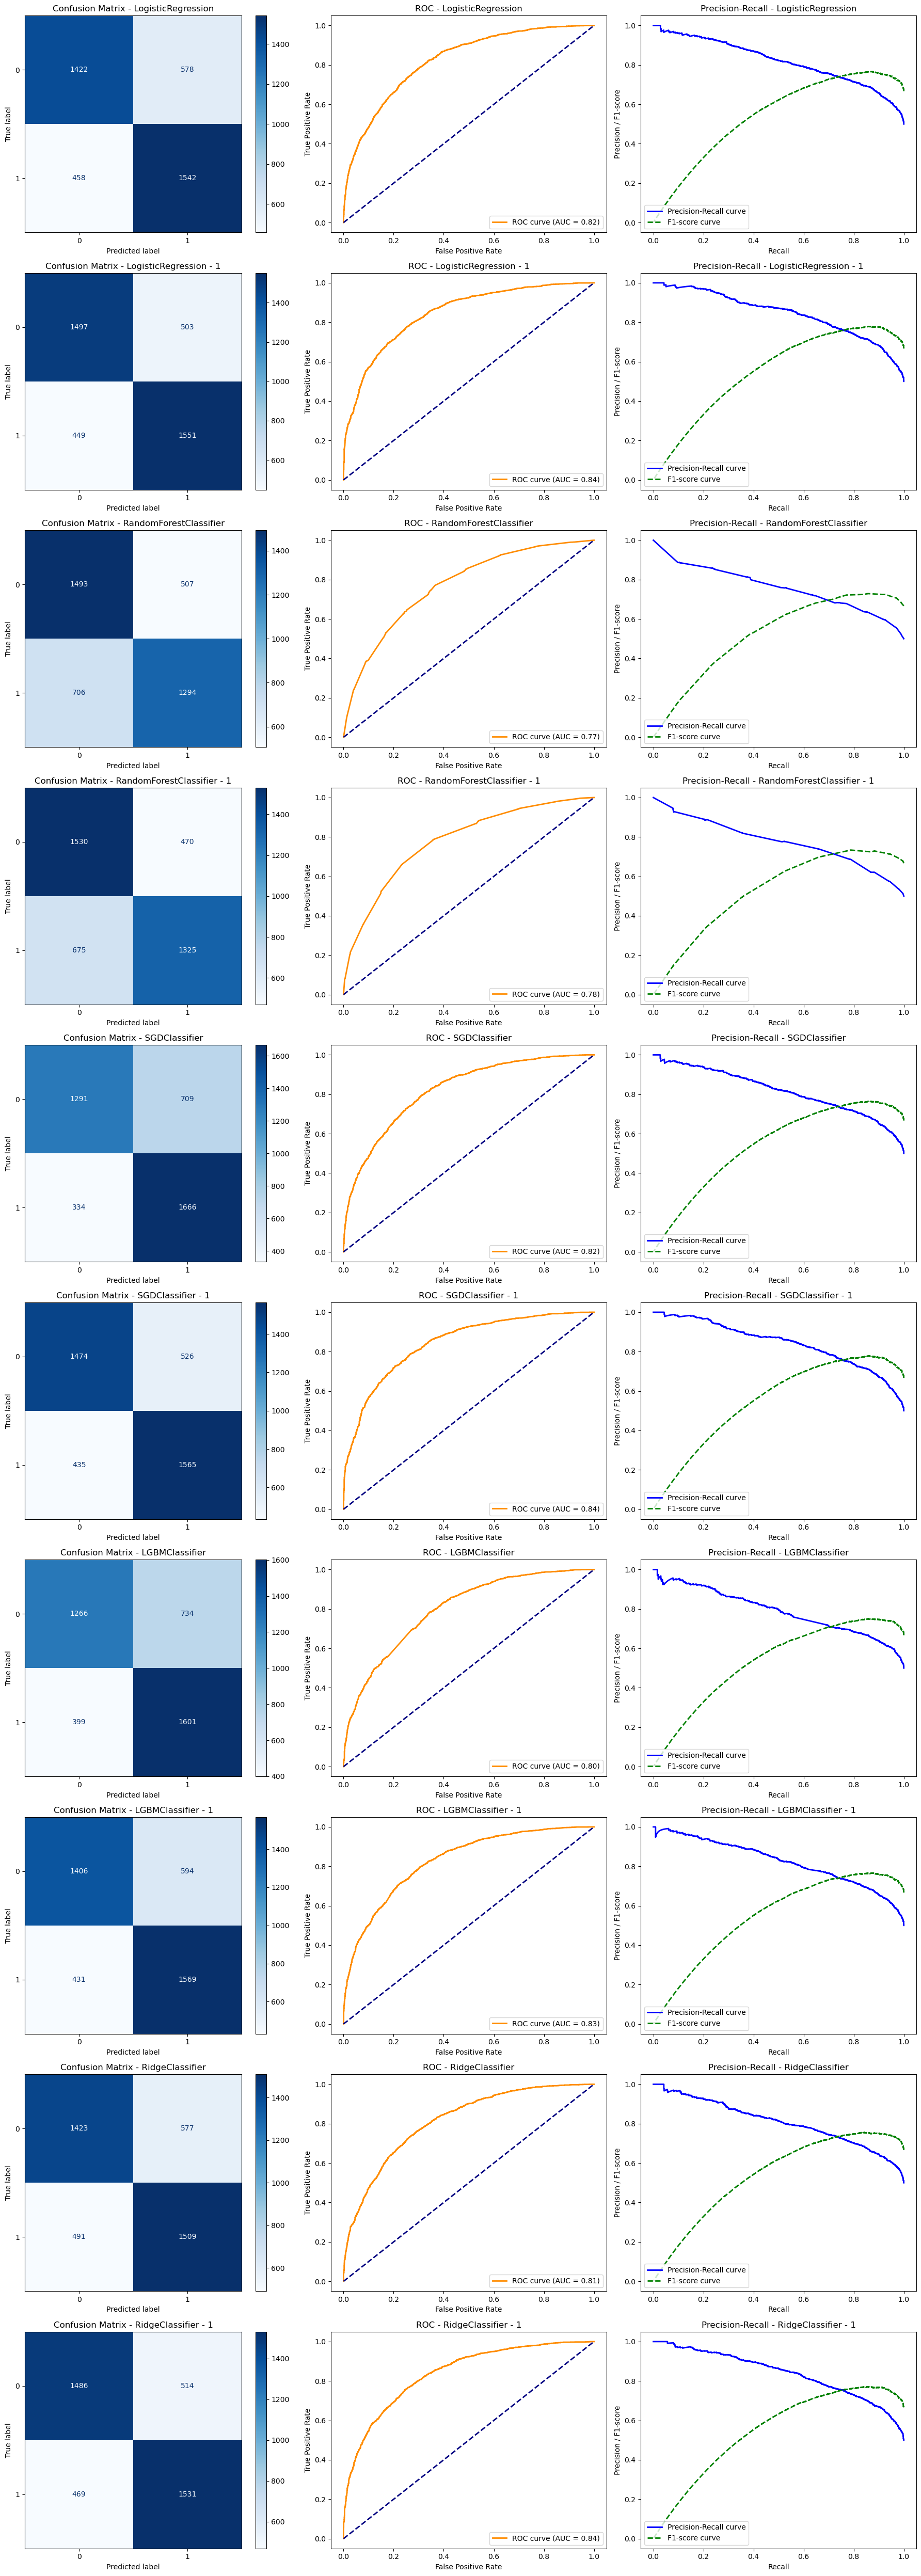

In [40]:
# Prédictions des probabilités ou scores pour chaque modèle
y_scores = {
    "LogisticRegression": model1.predict_proba(X_test)[:, 1],
    "LogisticRegression - 1": model11.predict_proba(X_test1)[:, 1],
    "RandomForestClassifier": model2.predict_proba(X_test)[:, 1],
    "RandomForestClassifier - 1": model22.predict_proba(X_test1)[:, 1],
    "SGDClassifier": model3.decision_function(X_test),
    "SGDClassifier - 1": model33.decision_function(X_test1),
    "LGBMClassifier": model4.predict_proba(X_test)[:, 1],
    "LGBMClassifier - 1": model44.predict_proba(X_test1)[:, 1],
    "RidgeClassifier": model5.decision_function(X_test),
    "RidgeClassifier - 1": model55.decision_function(X_test1)
}

y_preds = {
    "LogisticRegression": y_pred1,
    "LogisticRegression - 1": y_pred11,
    "RandomForestClassifier": y_pred2,
    "RandomForestClassifier - 1": y_pred22,
    "SGDClassifier": y_pred3,
    "SGDClassifier - 1": y_pred33,
    "LGBMClassifier": y_pred4,
    "LGBMClassifier - 1": y_pred44,
    "RidgeClassifier": y_pred5,
    "RidgeClassifier - 1": y_pred55
}

fig, axes = plt.subplots(len(y_scores), 3, figsize=(18, 50))

for row, (model_name, y_score) in enumerate(y_scores.items()):
    y_pred = y_preds[model_name]
    y_true = y_test if "- 1" not in model_name else y_test1
    
    # Matrice de confusion
    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_true, y_pred),
        display_labels=np.unique(y_true)
    ).plot(ax=axes[row, 0], cmap=plt.cm.Blues)
    axes[row, 0].set_title(f"Confusion Matrix - {model_name}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    axes[row, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[row, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[row, 1].set_xlabel('False Positive Rate')
    axes[row, 1].set_ylabel('True Positive Rate')
    axes[row, 1].set_title(f'ROC - {model_name}')
    axes[row, 1].legend(loc="lower right")

    # Precision-Recall Curve avec F1-score
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    f1 = (2 * precision * recall) / (precision + recall + 1e-6)  # F1-score
    
    axes[row, 2].plot(recall, precision, color='b', lw=2, label='Precision-Recall curve')
    axes[row, 2].plot(recall, f1, color='g', lw=2, linestyle='--', label='F1-score curve')
    axes[row, 2].set_xlabel('Recall')
    axes[row, 2].set_ylabel('Precision / F1-score')
    axes[row, 2].set_title(f'Precision-Recall - {model_name}')
    axes[row, 2].legend(loc="lower left")

plt.tight_layout()
plt.show()

In [48]:
# Tableau final qui permet de comparer entre les différents modèles
# Liste des modèles et leurs prédictions
model_names = [
    "LogisticRegression", "LogisticRegression - 1",
    "RandomForestClassifier", "RandomForestClassifier - 1",
    "SGDClassifier", "SGDClassifier - 1",
    "LGBMClassifier", "LGBMClassifier - 1",
    "RidgeClassifier", "RidgeClassifier - 1"
]

# Correspondance des vrais labels et des prédictions
y_tests = [y_test, y_test1, y_test, y_test1, y_test, y_test1, y_test, y_test1, y_test, y_test1]
y_preds_list = [y_pred1, y_pred11, y_pred2, y_pred22, y_pred3, y_pred33, y_pred4, y_pred44, y_pred5, y_pred55]
y_scores_list = [
    y_scores["LogisticRegression"], y_scores["LogisticRegression - 1"],
    y_scores["RandomForestClassifier"], y_scores["RandomForestClassifier - 1"],
    y_scores["SGDClassifier"], y_scores["SGDClassifier - 1"],
    y_scores["LGBMClassifier"], y_scores["LGBMClassifier - 1"],
    y_scores["RidgeClassifier"], y_scores["RidgeClassifier - 1"]
]

# Liste pour stocker les résultats
results = []

# Calcul des métriques pour chaque modèle
for model_name, y_true, y_pred, y_score in zip(model_names, y_tests, y_preds_list, y_scores_list):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Calcul des métriques
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    specificity = tn / (tn + fp)  # Spécificité
    error_rate = (fp + fn) / (fp + fn + tp + tn)  # Taux d'erreur
    mcc = matthews_corrcoef(y_true, y_pred)  # Matthews Correlation Coefficient
    auc_roc = roc_auc_score(y_true, y_score)  # AUC-ROC

    results.append([model_name, fp, tp, fn, tn, precision, recall, f1, accuracy, specificity, error_rate, mcc, auc_roc])

# Création du DataFrame
columns = ["Modèle", "FP", "VP", "FN", "VN", "Précision", "Rappel", "F1-score", "Accuracy", "Spécificité", "Taux d'erreur", "MCC", "AUC-ROC"]
df_results = pd.DataFrame(results, columns=columns)

# Affichage du tableau
display(df_results)

Modèle   FP    VP   FN    VN  Précision  Rappel  \
0          LogisticRegression  578  1542  458  1422   0.727358  0.7710   
1      LogisticRegression - 1  503  1551  449  1497   0.755112  0.7755   
2      RandomForestClassifier  507  1294  706  1493   0.718490  0.6470   
3  RandomForestClassifier - 1  470  1325  675  1530   0.738162  0.6625   
4               SGDClassifier  709  1666  334  1291   0.701474  0.8330   
5           SGDClassifier - 1  526  1565  435  1474   0.748446  0.7825   
6              LGBMClassifier  734  1601  399  1266   0.685653  0.8005   
7          LGBMClassifier - 1  594  1569  431  1406   0.725381  0.7845   
8             RidgeClassifier  577  1509  491  1423   0.723394  0.7545   
9         RidgeClassifier - 1  514  1531  469  1486   0.748655  0.7655   

   F1-score  Accuracy  Spécificité  Taux d'erreur       MCC   AUC-ROC  
0  0.748544   0.74100       0.7110        0.25900  0.482870  0.822688  
1  0.765170   0.76200       0.7485        0.23800  0.524191  0.844591  
2  0.680873   0.69675       0.7465        0.30325  0.395462  0.769412  
3  0.698287   0.71375       0.7650        0.28625  0.429764  0.779043  
4  0.761600   0.73925       0.6455        0.26075  0.487140  0.821081  
5  0.765094   0.75975       0.7370        0.24025  0.520039  0.842307  
6  0.738639   0.71675       0.6330        0.28325  0.439712  0.797121  
7  0.753783   0.74375       0.7030        0.25625  0.489127  0.827106  
8  0.738620   0.73300       0.7115        0.26700  0.466431  0.813137  
9  0.756984   0.75425       0.7430        0.24575  0.508629  0.837954